# Лабораторная работа № 7. Ансамблевые модели для прогнозирования температуры блока усиления мощности.

В работе проводится обзор основных ансамблевых моделей машинного обучения по прогнозированию временного ряда. В качестве примера рассмотрена температура блока усиления мощности.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу.  Техническое состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача, решаемая в рамках данной лабораторной работы - спрогнозировать будущее значение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков. Последний определяет тип сигнала, передаваемый на БУМ, а поэтому определяет интенсивность нагрева.

Существует 2 основных подхода к прогнозированию временного ряда методами машинного обучения. В обоих подходах обучающая выборка состоит из ретроспективных данных о функционировании блока. Отличие состоит в том, что выбирается в качестве целевой переменной. 

В первом подходе определяется значение временного ряда (температуры) на следующем отсчете времени (целевая переменная - 1-мерная). Тогда прогнозные значения на каком-то интервале времени будут получаться путем последовательного прогнозирования значения ряда на 1 временной отсчет. При этом ошибка неизбежно накапливается, поскольку каждое прогнозное значение имеет свою неустранимую ошибку.

В другом подходе в качестве целевой переменной выбирается сразу интервал значений длиной *n* (целевая переменная *n*-мерная). Такой подход лишен недостатка в виде накопления ошибки, как в первом подходе. Однако, в этом случае сам метод прогнозирования сложнее и требует больших временных затрат и больших вычислительных мощностей.

В данной лабораторной работе мы остановимся на первом подходе.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [2]:
df = pd.read_csv("Lab7_data.csv")
df.head()

,mode,temp1,temp2,temp3
0,3,28.286114,28.043155,27.282141
1,4,34.142434,35.346311,34.829661
2,2,34.813586,36.781106,34.445407
3,4,39.946499,43.133120,40.372435
4,4,43.950857,47.014358,44.162152


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mode    1205950 non-null  int64  
 1   temp1   1205950 non-null  float64
 2   temp2   1205950 non-null  float64
 3   temp3   1205950 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 36.8 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Анализ каждого из режимов был выполнен в предыдущей лабораторной работе. Следующие 3 колонки в датасете содержат в себе информацию о температуре каждого из 3-х БУМ в каждый момент времени.

Для простоты рассмотрим только 1-й блок и будем прогнозировать только его температуру.

In [4]:
df = df[['mode','temp1']].rename(columns={'temp1':'temp'})

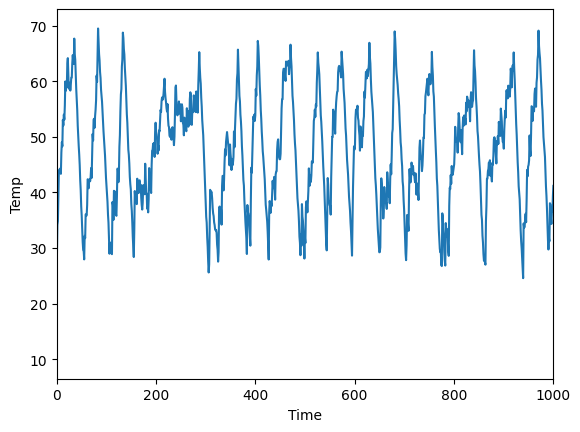

In [5]:
plt.plot(df['temp'])
plt.xlim(0,1000)
plt.xlabel('Time')
plt.ylabel('Temp')
plt.show()

## Подготовка данных

### Нормирование

#### **Задание 1** 

Температура, записанная в таблице **df** измеряется в градусах Цельсия. Однако для применения различных моделей машинного обучения желательно нормировать данные, чтобы ограничить их максимальные и минимальные значения. Отнормируем значения температуры на отрезок \[0,1\]. Сохраненные значения **max_value** и **min_value** позволят после выполнения прогноза вернуться к реальным значениям температуры.  

In [6]:
def normalize(series):
    # Напишите здесь свой код
    mms        = lambda t, t_min, t_max: (t - t_min) / (t_max - t_min)
    min_value  = min(series)
    max_value  = max(series)
    normalized = mms(t=series, t_min=min_value, t_max=max_value)
    return normalized, max_value, min_value

In [7]:
normalized, max_value, min_value = normalize(df['temp'])
df.loc[:,'temp'] = normalized

### Создание тестовой выборки

В качестве тестовой выборки будем использовать последовательность значений температур определенной длины **seq_length** и режим работы в конце этой последовательности. При этом стоит обратить внимание на то, что режим работы в какой-то временной отсчет $mode_i$ определяет значение температуры в тот же самый отсчет времени $T_i$. Поэтому обучающая выборка должна состоять из значений:

$$
X = \{T_{N-seq\_length+1}, ..., T_{N-1}, T_{N}, mode_{N+1}\}.
$$

В то время как целевая переменная является просто последующим значением температуры:

$$
y = T_{N+1}.
$$

Воспользуемся функцией, написанной в прошлой лабораторной работе, которая будет создавать обучающую и тестовую выборку объемом **N**, где длина обучающей последовательности равна **seq_length**.

In [8]:
def get_sequences(df, N, seq_length):
    if N + seq_length > len(df) - 1:
        N = len(df) - seq_length - 1
    X = None
    y = None
    pos = 1
    while pos < N:
        seq = np.append(df.loc[pos:pos+seq_length-1, 'temp'].values, df.loc[pos+seq_length, 'mode'].astype('float64'))
        X = np.vstack((X, seq)) if X is not None else seq
        y_val = df.loc[pos+seq_length, 'temp'].astype('float64')
        y = np.append(y, y_val) if y is not None else np.array(y_val)
        pos += 1
    return X, y

Создадим обучающую и тестовую выборки

In [9]:
size = 10000
seq_length = 40

X, y = get_sequences(df, size, seq_length)

## Ансамблевые модели машинного обучения

Мотивация применения ансамблевых методов состоит в том, чтобы объединить прогнозы нескольких базовых моделей, построенных с заданным алгоритмом обучения и улучшить качество прогноза.

Обычно выделяют два семейства ансамблевых методов:

- в методах усреднения (бэггинга) главный принцип состоит в том, чтобы построить несколько моделей независимо, а затем усреднить их прогнозы. В среднем, комбинированная оценка обычно лучше, чем любая из оценок отдельной модели, потому что дисперсия ее ошибки прогноза уменьшается.

- в методах бустинга базовые модели строятся последовательно, и каждая пытается уменьшить ошибку прогноза предыдущей модели. Идея состоит в том, чтобы объединить несколько слабых моделей для создания мощного ансамбля. 

## Бэггинг

В ансамблевых алгоритмах бэггинга создается несколько экземпляров базовой модели на случайных подмножествах исходной обучающей выборки, а затем агрегируются индивидуальные прогнозы этих моделей для формирования окончательного прогноза. Такой подход используется как способ уменьшить дисперсию базовой модели (например, дерева решений) путем введения случайности в процедуру построения моделей и последующего создания из них ансамбля. Во многих случаях методы бэггинга представляют собой очень простой способ улучшения базовой модели, без необходимости ее специальной настройки. Поскольку бэггинг обеспечивает способ уменьшения переобучения, этот подход лучше всего работает с сильными и сложными моделями (например, полностью разработанными деревьями решений), в отличие от методов бустинга, которые обычно лучше всего работают со слабыми моделями (например, с неглубокими деревьями решений).

Методы бэггинга бывают разных видов, но в основном отличаются друг от друга тем, как они создают случайные подмножества обучающей выборки:

- метод вставки - обучающие выборки создаются как случайные подмножества исходной выборки.

- метод бутстрэпа - обучающие выборки создаются как исходная выборка с повторениями, т.е. некоторые, случайные элементы исходной выборки дублируются.

- метод случайного подпространства - обучающие выборки создаются как случайные подмножества признаков.

- метод случайных исправлений - базовые модели обучаются на подмножествах как исходной обучающей выборки, так и признаков.

### Создание обучающей выборки методом бутстрэпа

#### **Задание 2** 

Реализуйте метод формирования обучающих выборок бутстрэпом. Функция **get_bootstrap_samples(data_X, data_y, n_samples)** принимает на вход исходную выборку **data_X, data_y** и число выходных обучающих выборок **n_samples**, а возвращает совокупность обучающих выборок размером **(n_samples, len(data_X))**. Внутри функции необходимо случайным образом из исходной выборки **n_samples** раз выбрать элементы (с повторениями).

In [43]:
def get_bootstrap_samples(data_X, data_y, n_samples):
    n = np.random.randint(0, len(data_X), (n_samples, len(data_X)))
    samples_X = data_X[n]
    samples_y = data_y[n]

    return (samples_X, samples_y)

#### **Задание 3** 

Реализуйте функцию **regr_mape(y_pred, y_test)**, которая подсчитывает значение метрики **MAPE** (Mean Absolut Percentage Error - средняя абсолютная ошибка) для прогнозных **y_pred** и истинных значений **y_test** температуры. Также реализуйте функцию **train(model, model_name, evaluate, X_train, y_train, X_test, y_test)**, которая будет обучать заданную модель **model**. Переменная **evaluate** обозначает метод, который используется для оценки точности прогнозных значений (например, **regr_mape()**). Функция **train()** должна выдавать на выходе значение точности прогноза на обучающей выборке, точности прогноза на тестовой выборке и массив самих прогнозных значений. 

In [39]:
def regr_mape(y_pred, y_test):
    # Напишите свой код здесь
    mape = np.mean(abs((y_pred - y_test) / y_test))
    return mape

def train(model, model_name, evaluate, X_train, y_train, X_test, y_test):

    # Напишите здесь свой код
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score_test = evaluate(y_pred, y_test)
    y_pred_train = model.predict(X_train)
    score_train = evaluate(y_pred_train, y_train)

    return (score_train, score_test, y_pred)

Создайте 1000 обучающих выборок и обучите на них 1000 моделей **DecisionTreeRegressor** с оптимальными параметрами, найденными в предыдущей лабораторной работе. Затем получите прогнозы температуры для тестовой выборки.

In [40]:
n_samples = 1000
train_len = 8000
X_train = X[:train_len]
y_train = y[:train_len]
X_test = X[train_len:]
y_test = y[train_len:]

#### **Задание 4** 

In [44]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=3, min_samples_leaf=2, random_state=0)

results = get_bootstrap_samples(X_train, y_train, n_samples)
predictions = []

# Напишите здесь свой код
X_bootstrap = np.array(results[0])
y_bootstrap = np.array(results[1])

from joblib import Parallel, delayed, parallel_backend

train_res = None

# with parallel_backend('threading', n_jobs=-1):
train_res = Parallel(n_jobs=-1)\
        (delayed(train)(dtr, 'Decision Tree', regr_mape, X_bootstrap[i], y_bootstrap[i], X_test, y_test) for i in range(len(X_bootstrap)))

# with parallel_backend('threading', n_jobs=-1):
  # for i in range(len(X_bootstrap)):
  #   score_train, score_test, y_pred = train(dtr, 'Decision Tree', regr_mape, X_bootstrap[i], y_bootstrap[i], X_test, y_test)
  #   predictions.append(y_pred)

In [45]:
predictions = []
for i in range(len(X_bootstrap)):
  score_train, score_test, y_pred = train_res[i]
  predictions.append(y_pred)
predictions = np.asarray(predictions)

### Прогнозирование временного ряда методом бутстрэпа

Техника бутстрэпа позволяет не просто выдать прогноз в виде определенного значения, но выдать прогноз в виде набора возможных значений, что позволяет оценить доверительный интервал для полученного прогноза. Для примера построим гистограмму распределения для первого прогнозного значения температуры.

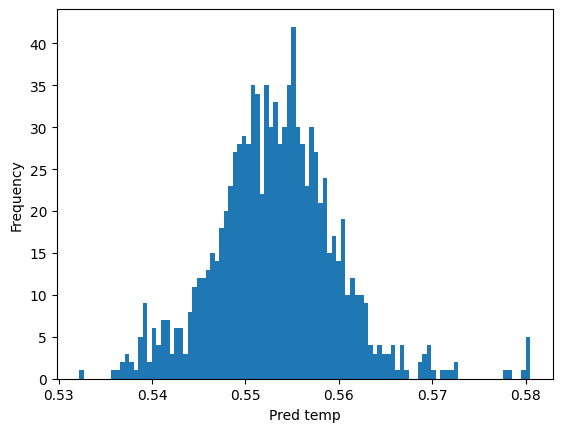

In [46]:
plt.figure()
plt.hist(predictions[:,0], bins=100)
plt.xlabel('Pred temp')
plt.ylabel('Frequency')
plt.show()

#### **Задание 5** 

Напишите функцию **stat_intervals(stat, alpha)** для определения доверительного интервала для набора данных **stat** с заданным доверительным уровнем ошибки **alpha** (т.е. если alpha = 0.1, то вероятность того, что искомая величина попадает в доверительный интервал равна 90 %). Функция должна выдавать пару значений: верхнюю и нижнюю границы.

In [47]:
from scipy.stats import t
def stat_intervals(stat, alpha):
    boundaries = []

    mean = np.mean(stat)
    n = len(stat)
    std = np.std(stat)
    
    boundaries.append( t.ppf(0 + alpha/2, n - 1, loc = mean, scale = std) )
    boundaries.append( t.ppf(1 - alpha/2, n - 1, loc = mean, scale = std) )
    return boundaries

Определим доверительный интервал первого спрогнозированного значения для вероятности 95 %.

In [48]:
interval = stat_intervals(predictions[:,0], 0.05)
interval

[0.5402691773182547, 0.5662403983183916]

Функция **train()** в результате своей работы также выдала результаты прогноза значений температуры на длительный интервал времени. На основании спрогнозированных значений температуры множеством моделей получите для каждого спрогнозированного значения среднее, а также доверительный интервал с уровнем доверия 95 %. Далее постройте график изменения температуры, на котором отразите истинные значения температуры, средние спрогнозированные значения, а также доверительные интервалы.

#### **Задание 6** 

In [51]:
alpha = 0.05

means = np.apply_along_axis(np.mean, 0, predictions)
boundaries = np.asarray([stat_intervals(predictions[:,i], alpha) for i in range(len(predictions[0]))])

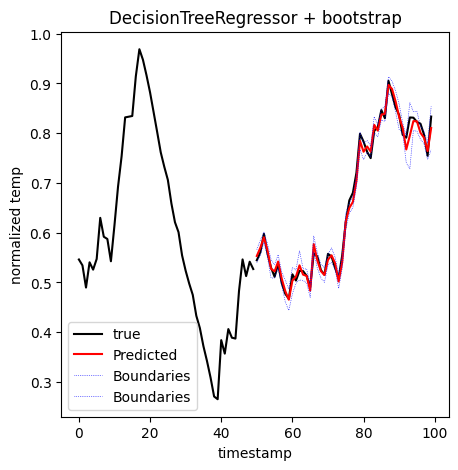

In [53]:
plt.figure(figsize=(5,5))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('DecisionTreeRegressor + bootstrap')

plt.plot(x2, means[:length], c='red', label='Predicted')
plt.plot(x2, boundaries[:length], 'b:', linewidth = 0.5, label='Boundaries')
plt.legend()

plt.show()

#### **Задание 7** 

Определите точность усредненного прогноза и сравните его с точностью прогноза одной модели **DecisionTreeRegressor**.

In [54]:
# Напишите здесь свой код
score_bootstrap_dtr = regr_mape(means, y_test)

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=3, min_samples_leaf=2, random_state=0)
results = train(dtr, 'dtr', regr_mape, X_train, y_train, X_test, y_test)
score_dtr = results[1]

print('MAPE for single model: {:.5f}'.format(score_dtr))
print('MAPE for bootstrap model: {:.5f}'.format(score_bootstrap_dtr))

MAPE for single model: 0.01943
MAPE for bootstrap model: 0.01686


**Выводы:** 

Для модели решающего дерева метод *bootstrap* повысил точность.

### Случайный лес

Другой реализацией бэггинга (метода устреднения) является модель под названием "случайный лес", или **RandomForest**. Он может применяться как для решения задачи классификации - [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier "RandomForestClassifier"), так и для решения задачи регрессии - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor "RandomForestRegressor"). Назван эта модель так, потому что она состоит из нескольких моделей **DecisionTree**, у каждой из которых случайным образом выбраны два параметры: наполнение обучающей выборки и максимальное число используемых признаков. По сути это и есть реализация метода бутстрэп и метода случайного подпространства признаков (о которых речь была выше), но на моделях решающего дерева. Итоговый прогноз получается в результате усреднения прогноза каждой из моделей. За счет рандомизации параметров моделей и их большого числа достигается увеличение качества работы "случайного леса".

Обучите модель **RandomForestRegressor** на тех же данных, что и нашу собственную модель на основе бутсnрэпа. Параметры у модели **RandomForestRegressor** такие же, как и у **DecisionTreeRegressor**, только добавляется **n_estimators** - число простых моделей в итоговой модели, **max_features** - максимальное число признаков, которое будет анализироваться, и **bootstrap** - использовать или нет метод бутстрэпа. Подберите оптимальное значение **n_estimators**, **max_depth**, **min_samples_split**.

#### **Задание 8** 

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators = 10,
    max_depth = 2,
    min_samples_split = 2,
    random_state = 0)

In [56]:
# Напишите здесь свой код
results = dict()
scores = []

error_min = 1
estimators_opt = 10
depth_opt = 2
opt_split = 2

for est in range(10, 20):
    for depth in range(2, 10):

        for split in range(2,5):
            rf = RandomForestRegressor(
            n_estimators = est,
            max_depth = depth,
            min_samples_split = 2,
            random_state = 0)
            results = train(rf, 'Random forest', regr_mape, X_train, y_train, X_test, y_test)
            if (results[1] < error_min).any():
                opt_est = est
                opt_split = split
                opt_depth = depth
                error_min = score_test

print('Optimal parameters')
print('estimators: {} max_depth: {} min_samples_split: {}'.format(opt_est, opt_depth, opt_split))

KeyboardInterrupt: 

#### **Задание 9** 

Обучите модель с оптимальными параметрами, найденными выше. Определите финальное качество прогноза на тестовой выборке. Постройте график прогнозных значений температуры.

In [ ]:
# Напишите здесь свой код
rf = RandomForestRegressor(
    n_estimators = ..., 
    max_depth = ..., 
    min_samples_split = ..., 
    random_state = 0)
(score_train, score_rf, preds) = train(rf, 'rf', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for RandomForest model: {:.5f}'.format(score_rf))

In [ ]:
plt.figure(figsize=(5,5))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('RandomForestRegressor')

# Напишите здесь свой код

plt.show()

## Метод бустинга

### AdaBoost

Эта модель является одной из самых популярных реализаций методов бустинга и была разработана в 1995 году Фройндом и Шапиро. Основной принцип AdaBoost состоит в том, чтобы обучить последовательность "слабых" моделей (то есть моделей, которые лишь немного лучше, чем случайный прогноз, такие как небольшие деревья решений) на многократно изменяемых версиях данных. Прогнозы от всех из них затем объединяются посредством взвешенного большинства голосов (или суммы) для получения окончательного прогноза. Модификации данных на каждой так называемой итерации бустинга состоят в применении весов к каждой обучающей выборке. Первоначально все эти веса установлены равными, поэтому на первом этапе просто обучается "слабая" модель на исходных данных. Для каждой последующей итерации веса выборки индивидуально изменяются, и алгоритм обучения повторно применяется к повторно взвешенным данным. На данном этапе те обучающие примеры, которые были неправильно предсказаны усиленной моделью, созданной на предыдущем шаге, имеют увеличенные веса, тогда как веса уменьшаются для тех, которые были предсказаны правильно. По мере продолжения итераций, примеры, которые трудно предсказать, получают все большее влияние. Таким образом, каждая последующая "слабая" модель вынуждена концентрироваться на примерах, которые упускают предыдущие модели. 

Модель AdaBoost позволяет решать как задачи классификации, так и задачи регрессии. Создайте объект [**AdaBoostRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor "AdaBoostRegressor"). Параметр **base_estimator** задает "слабую" модель, которая будет использоваться для бустинга, **n_estimators** обозначает число "слабых" моделей в последовательности. Параметр **learning_rate** определяет вес, на который домножаются примеры из обучающей выборки. Этот параметр очень важен и играет роль регуляризации: чем он меньше, тем медленнее идет обучение, но тем "лучше" оно проходит. Наконец параметр **loss** определяет функцию (она называется функция потерь), по которой на каждой итерации бустинга рассчитывается штраф за неверно предсказанное значение и определяются веса, на которые нужно домножить примеры из обучающей выборки на следующей итерации бустинга. Доступные функции потерь - линейная, квадратичная и экспоненциальная.

Обучите модель AdaBoost на двух "слабых" моделях: решающее дерево (с оптимальными параметрами, найденными выше) и линейная регрессия. Подберите оптимальным образом параметры **learning_rate** и **n_estimators** Определите качество прогноза на тех же самых тестовых данных, что и выше.

#### **Задание 10** 

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=2, random_state=0)
lr = LinearRegression()

In [ ]:
# Напишите здесь свой код


In [ ]:
# Напишите здесь свой код
adaboost_dtr = AdaBoostRegressor(
        base_estimator = dtr,
        n_estimators = ..., 
        learning_rate = ..., 
        random_state = 0)
adaboost_lr = AdaBoostRegressor(
        base_estimator = lr,
        n_estimators = ..., 
        learning_rate = ..., 
        random_state = 0)
(score_train, score_adaboost_dtr, preds_adaboost_dtr) = train(adaboost_dtr, 'adaboost_dtr', regr_mape, X_train, y_train, X_test, y_test)
(score_train, score_adaboost_lr, preds_adaboost_lr) = train(adaboost_lr, 'adaboost_lr', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for AdaBoost on DecisionTree model: {:.5f}'.format(score_adaboost_dtr))
print('MAPE for AdaBoost on LinearRegression model: {:.5f}'.format(score_adaboost_lr))

#### **Задание 11** 

Постройте сравнительный график прогнозных значений температуры обоих моделей.

In [ ]:
plt.figure(figsize=(5,5))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('AdaBoost')

# Напишите здесь свой код

plt.show()

**Выводы:**

сделайте выводы

### Gradient Tree Boosting

В модели **AdaBoost** есть возможность выбора функции потерь, которая определяет каким образом будут распределены веса между примерами из обучающей выборки на следующей итерации бустинга, - линеная, квадратичная или экспоненциальная. Градиентный бустинг на решающих деревьях (Gradient Tree Boosting или **Gradient Boosted Decision Tree, GBDT**) - это обобщение на случай произвольных дифференцируемых функций потерь. **GBDT** - это эффективная модель процедура, которую можно использовать для решения задач регрессии и классификации в различных областях, включая ранжирование в веб-поиске и экологию.

Идея **GBDT** состоит в следующем. Итоговая модель представляет собой линеную комбинацию "слабых" моделей - решающих деревьев:

$$
F_M(x) = \sum^M_{m=1}h_m(x)
$$

На каждой итерации бустинга к итоговой модели добавляется новое решающее дерево:

$$
F_m(x) = F_{m-1}(x) + h_m(x),
$$

которое выбирается таким образом, чтобы минимизировать ошибку прогноза, т.е. функцию потерь $L(y, F(x))$, уже построенной к этой итерации модели:

$$
h_m = argmin_{h}L_m = argmin_h\sum^N_{i=1}L(y_i, F_{m-1}(x_i) + h(x_i))
$$

Построение этого нового решающего дерева ведется методом градиентного спуска для минимизации функции потерь:

$$
h_m \approx argmin_h\sum^N_{i=1}h(x_i)g_i, \quad g_i = \left.\dfrac{\partial L(y_i,F(x_i))}{\partial F(x_i)}\right|_{F=F_{m-1}}.
$$

#### **Задание 12** 

Постройте и обучите модель градиентного бустинга из пакета **LightGBM** - [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor "LGbMRegressor"). Эта реализации работает сильно быстрее по сравнению с реализацией в пакете Sklearn [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor "GradientBoostingRegressor"). Параметры этой модели те же самые, что и у **AdaBoost**.

Подберите оптимальным образом параметры num_leaves, max_depth, learning_rate и n_estimators. Оцените качетсво работы модели на том же тестовом датасете, что и предыдующие модели.

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

# Напишите здесь свой код


In [ ]:
# Напишите здесь свой код
lgbm = LGBMRegressor(num_leaves = ..., 
                     max_depth = ..., 
                     learning_rate = ..., 
                     n_estimators = ..., 
                     random_state = 0)
(score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))

#### **Задание 13** 

Постройте график прогнозных значений температуры.

In [ ]:
plt.figure(figsize=(5,5))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('LightGBM')

# Напишите здесь свой код

plt.show()

## Сравнение различных методов и моделей

Постройте для сравнения на одной гистограмме качество проанализированных моделей на тестовой выборке: обычное решающее дерево, решающее дерево с бутстрэпом, случайный лес, AdaBoost на линейной регрессии, AdaBoost на решающем дереве, градиентный бустинг на решающих деревьях LightGBM. Сделайте выводы.

In [ ]:
plt.figure(figsize=(10,5))
xx = ['DT', 'DT with Bootstrap', 'Random Forest', 'AdaBoost on LR', 'AdaBoost on DT', 'LightGBM']
yy = [score_dtr, score_bootstrap_dtr, score_rf, score_adaboost_lr, score_adaboost_dtr, score_lgbm]
rects = plt.bar(xx, yy)
plt.ylim(0, 0.025)
plt.ylabel('MAPE')
for i, rect in enumerate(rects):
    yloc = rect.get_height()
    xloc = rect.get_x() + rect.get_width() / 4
    plt.annotate(round(yy[i], 4), xy=(xloc, yloc), xytext=(xloc, 10),
                            textcoords="offset points",
                            va='center',
                            color='black', clip_on=True)

#### **Задание 14** 

**Выводы:**

сделайте выводы